In [126]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

# NB: background=True selects the train set, background=False selects the test set
# It's the nomenclature from the original paper, we just have to deal with it
image_size = 28
data_dir = '../data/omniglot'

# train set is list of (x, y) 
# where x is single image and y is label corresponding to it.
train_set = Omniglot(
    root=data_dir,
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = Omniglot(
    root=data_dir,
    background=False,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)

Files already downloaded and verified
Files already downloaded and verified


In [127]:
# help(train_set)

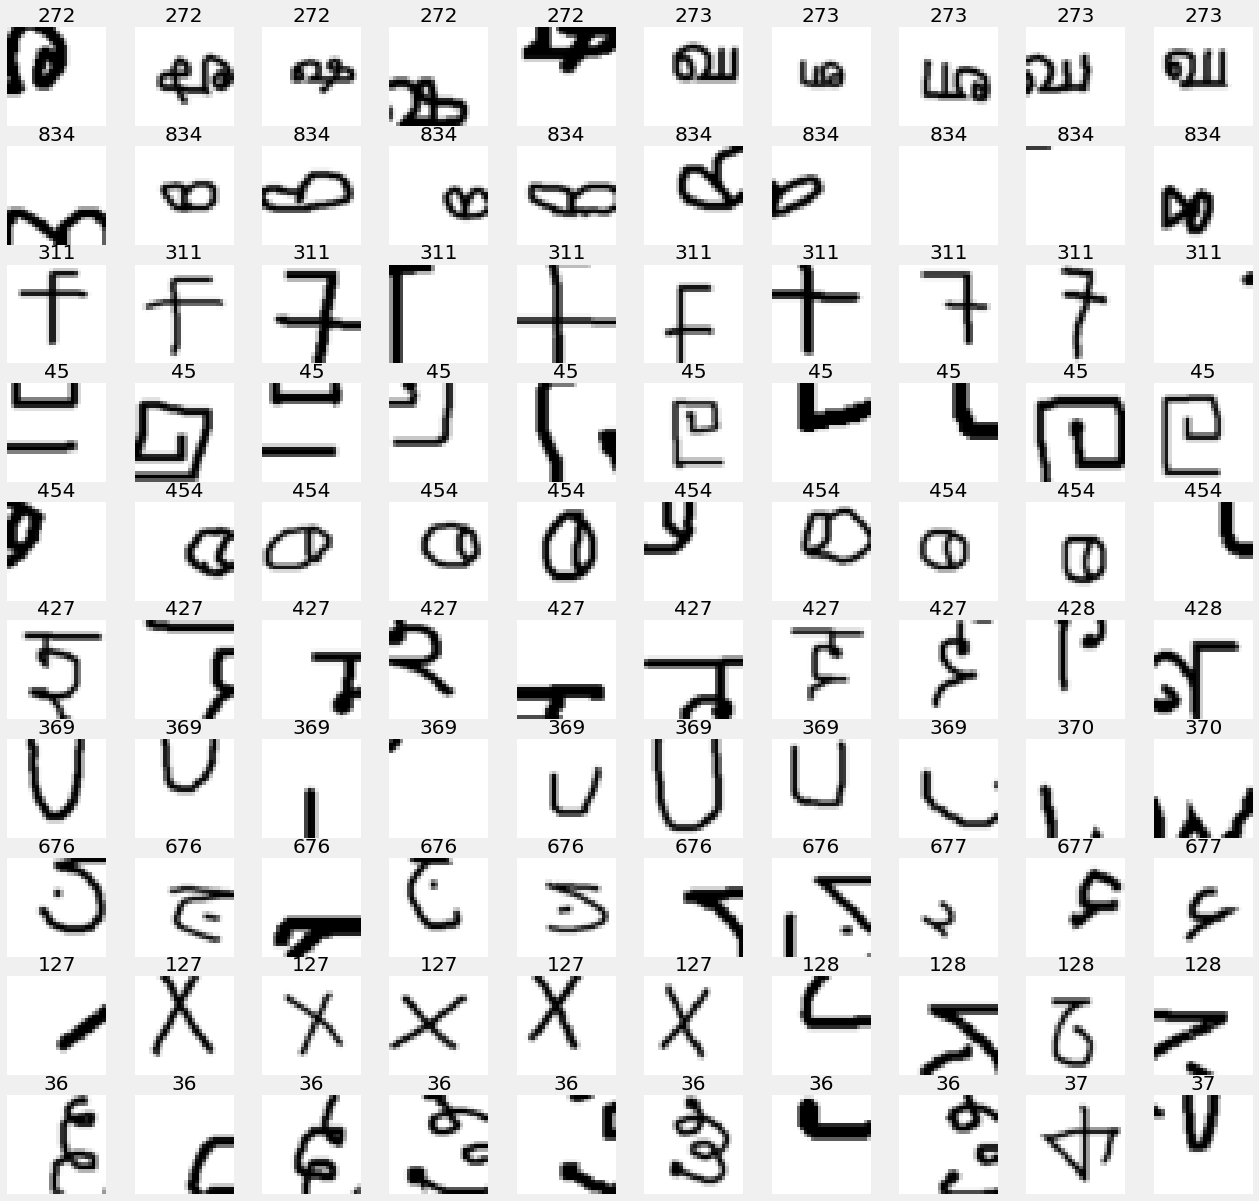

In [128]:
"""Iterate through dataset with transforms"""

import matplotlib.pyplot as plt
import numpy as np

ntrain = len(train_set) # 6000
idxs = np.random.choice(ntrain-10, 10)
fig, axs = plt.subplots(10,10, figsize=(20,20))
for i, idx in enumerate(idxs):
    for j in range(10):
        x, y = train_set[idx+j]
        axs[i][j].imshow(x.cpu().detach().permute(1,2,0).numpy())
        axs[i][j].axis('off')
        axs[i][j].set_title(str(y))
plt.show()

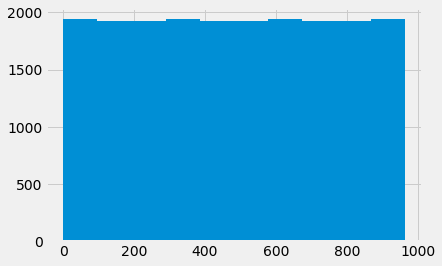

In [73]:
ys = [train_set[i][1] for i in range(len(train_set))]
plt.hist(ys)
plt.show()

In [75]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
test_set.get_labels = lambda: [
    instance[1] for instance in test_set._flat_character_images
]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

example_support_images torch.Size([25, 3, 28, 28])
example_support_labels torch.Size([25])
example_query_images torch.Size([50, 3, 28, 28])
example_query_labels torch.Size([50])
example_class_ids 5


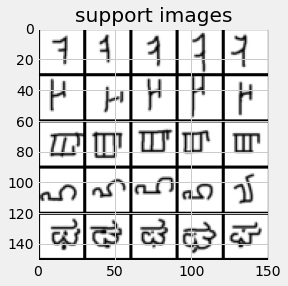

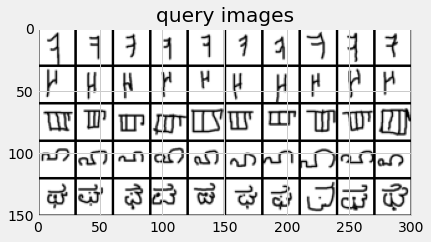

In [76]:
### VISUALIZE
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

for i in (
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
):
    x=[]
    if type(i)==list:
        x.append(len(i))
    else:
        x.append(i.shape)
    print(namestr(i, globals())[1], *x)

    
plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [ ]:
#### CUSTOM DATA

In [124]:
from pathlib import Path
from torch.utils.data import Dataset
# from torchvision.io import read_image
from PIL import Image


class CustomDataset(Dataset):
    @staticmethod
    def _validate_root_dir(root):
        # todo: raise exception or warning
        pass
    
    @staticmethod
    def _validate_train_flag(train: bool, valid: bool, test: bool):
        assert [train, valid, test].count(True)==1, "one of train, valid & test must be true."        
        
    def __init__(self, root,
                 train: bool = False, valid: bool = False, test: bool = False,
                 transform=None, target_transform=None,):

        self._validate_root_dir(root)
        self._validate_train_flag(train, valid, test)        
        self.transform = transform
        self.target_transform = target_transform
        if train:
            self.data_dir = Path(root)/'train'
        elif valid:
            self.data_dir = Path(root)/'valid'
        elif test:
            self.data_dir = Path(root)/'test'        
    
        self._image_paths = sorted(
            list(self.data_dir.glob("**/*.jpg"))+
            list(self.data_dir.glob("**/*.jpeg"))+
            list(self.data_dir.glob("**/*.png")))
        self._image_labels = [int(i.parent.name) for i in self._image_paths]
        assert len(self._image_paths)==len(self._image_labels)
        
    def __len__(self):
        return len(self._image_paths)
    
    def __getitem__(self, idx):
        x = Image.open(str(self._image_paths[idx]))
        y = self._image_labels[idx]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(x)
        return x, y
    
    def get_labels(self):
        return self._image_labels

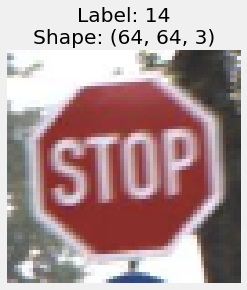

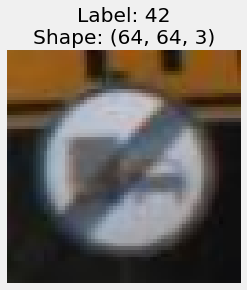

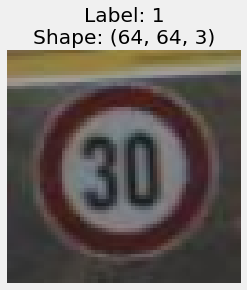

In [135]:
from torchvision.transforms import ToTensor

new_shape = (64,64)

ds_train = CustomDataset('../data/ssddir-traffic-signs', train=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(new_shape)]))
ds_valid = CustomDataset('../data/ssddir-traffic-signs', valid=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(new_shape)]))
ds_test  = CustomDataset('../data/ssddir-traffic-signs', test=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(new_shape)]))

 # need to add resize transform 
for ds in [ds_train, ds_valid, ds_test]:
    x, y = ds[420]
    im = x.detach().cpu().permute(1,2,0).numpy()
    plt.imshow(im)
    plt.title(f"Label: {y}\nShape: {im.shape}")
    plt.axis('off')
    plt.show()

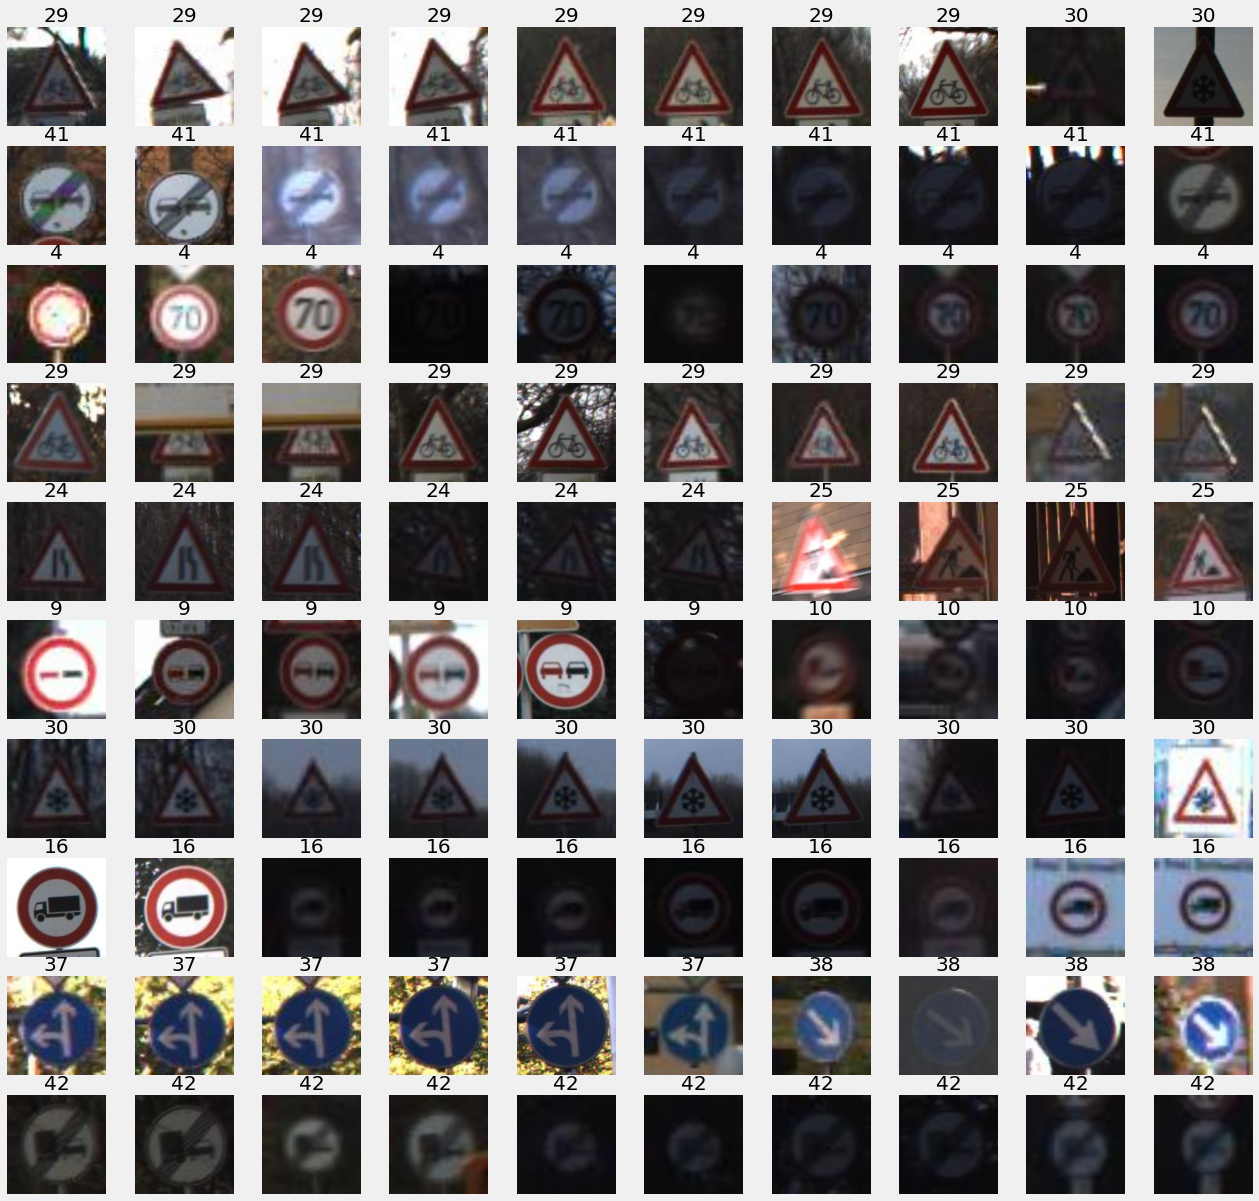

In [132]:
"""Iterate through dataset with transforms"""

import matplotlib.pyplot as plt
import numpy as np

ntrain = len(ds_train) # 6000
idxs = np.random.choice(ntrain-10, 10)
fig, axs = plt.subplots(10,10, figsize=(20,20))
for i, idx in enumerate(idxs):
    for j in range(10):
        x, y = ds_train[idx+j]
        axs[i][j].imshow(x.cpu().detach().permute(1,2,0).numpy())
        axs[i][j].axis('off')
        axs[i][j].set_title(str(y))
plt.show()

In [138]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

test_sampler = TaskSampler(
    ds_train, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    ds_train,
    batch_sampler=test_sampler,
    # num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

example_support_images torch.Size([25, 3, 64, 64])
example_support_labels torch.Size([25])
example_query_images torch.Size([50, 3, 64, 64])
example_query_labels torch.Size([50])
example_class_ids 5


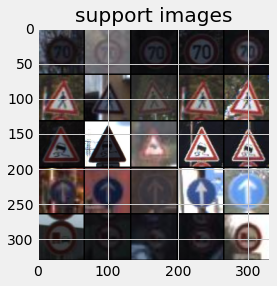

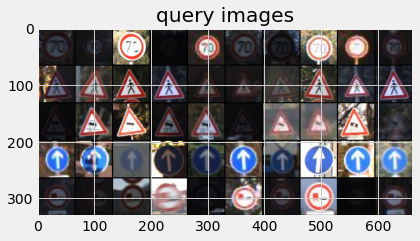

In [139]:
### VISUALIZE
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

for i in (
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
):
    x=[]
    if type(i)==list:
        x.append(len(i))
    else:
        x.append(i.shape)
    print(namestr(i, globals())[1], *x)
    
plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)